# Galaxy Image Classification 

### Column Descriptions

**training_predictions**: Probability distributions for the classifications for each of the training images.

**images_test**: JPG images of 79975 galaxies. Files are name according to their GalaxyId. You will provide probabilities for each of these images. (I don't use this)

**images_train**: JPG images of 61578 galaxies. Files are named according to their GalaxyId.

### Importing Libraries

In [38]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import io
import pickle
from skimage.transform import resize
import glob
import os
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

### Visualizing some of the training data

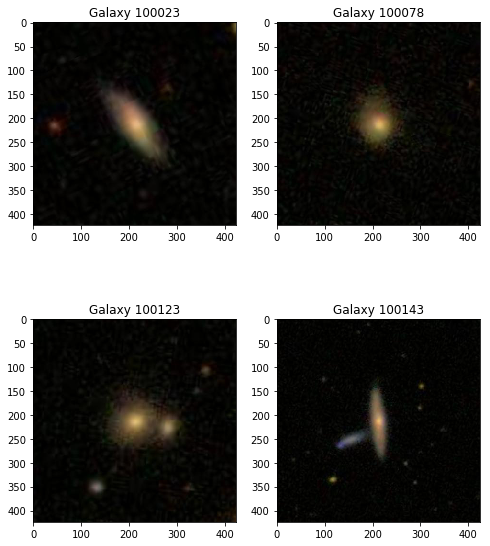

<Figure size 432x288 with 0 Axes>

In [2]:
#Let's look at four of our galaxies from the 61578 images in our training set. 

plt.figure(1, figsize=(8,10))
plt.subplot(221)
plt.imshow(plt.imread('images_training/100023.jpg'))
plt.title('Galaxy 100023')

plt.subplot(222)
plt.imshow(plt.imread('images_training/100078.jpg'))
plt.title('Galaxy 100078')

plt.subplot(223)
plt.imshow(plt.imread('images_training/100123.jpg'))
plt.title('Galaxy 100123')

plt.subplot(224)
plt.imshow(plt.imread('images_training/100143.jpg'))
plt.title('Galaxy 100143')

plt.show()
plt.tight_layout()

From the images above, as a scientist I can already tell what morphology these galaxies are of, but now the question is will the computer be able to classify them correctly. Let's first build a baseline model then compare it to a CNN model. 

### Visualize the predictions

In [3]:
import pandas as pd
import numpy as np

predictions = pd.read_csv('training_predictions.csv')
predictions.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


There seems to be ambigious headings for our columns and the resources on Kaggle don't seem to help much. Essentially, the classes refer to the morphology on the galaxy. 

In [4]:
(predictions['Class1.1'] + predictions['Class1.2'] + predictions['Class1.3']).head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64

In [5]:
predictions = predictions[['GalaxyID','Class1.1', 'Class1.2', 'Class1.3']]
predictions.head(10)

,GalaxyID,Class1.1,Class1.2,Class1.3
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161
5,100122,0.738832,0.238159,0.023009
6,100123,0.462492,0.456033,0.081475
7,100128,0.687783,0.288344,0.023873
8,100134,0.021834,0.976952,0.001214
9,100143,0.269843,0.730157,0.000000


Based on the images printed above, we can use our physics brain to determine what the columns stand for and rename the columns. 

In [6]:
predictions.columns = ['GalaxyID', 'Elliptical', 'Spiral', 'Irregular']
predictions.head()

,GalaxyID,Elliptical,Spiral,Irregular
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161


In [7]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61578 entries, 0 to 61577
Data columns (total 4 columns):
GalaxyID      61578 non-null int64
Elliptical    61578 non-null float64
Spiral        61578 non-null float64
Irregular     61578 non-null float64
dtypes: float64(3), int64(1)
memory usage: 1.9 MB


### Load all images of training data

In [8]:
image_path = ['images_training/' + galaxyid + '.jpg' for galaxyid in predictions['GalaxyID'].astype(str)]
image_path[:5]

['images_training/100008.jpg',
 'images_training/100023.jpg',
 'images_training/100053.jpg',
 'images_training/100078.jpg',
 'images_training/100090.jpg']

Even though im=cv2.imread(filename) was also tried and it ran faster, cv2 is less compatible and reads images blue green red which means if anyone else wanted to reproduce the results the models would not work. 

In [39]:
%%time
image_list = []
if 'images.pkl' in os.listdir('.'):
    image_list = pickle.load(open('images.pkl','rb'))
else:
    for i, filename in enumerate(glob.glob('images_training/*.jpg')): 
        im=io.imread(filename)
        image_resized = resize(im, (64, 64),
                       anti_aliasing=True)
        image_list.append(im)
    
    file = open('images.pkl','wb')
    pickle.dump(image_list,file)
    file.close()

# wb means write binary since our images.pkl is not a string. 
#time: CPU times: user 2min 38s, sys: 20.1 s, total: 2min 53s
# Wall time: 3min 54s

CPU times: user 16min 49s, sys: 2min 10s, total: 19min
Wall time: 22min 50s


### We need to reshape 

### Baseline Model

### Cross-Validation

### Run CNN model

### Compare the two models 